In [4]:
import gc 
gc.collect()

0

In [5]:
import numpy as np
import pandas as pd 
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments, AutoModelForSequenceClassification
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.cm as cm

2024-05-11 13:29:00.514466: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 13:29:01.422242: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
# tested in transformers==4.18.0, pytorch==1.7.1 
import torch
import transformers
torch.__version__, transformers.__version__

('1.13.0+cu117', '4.40.0')

*Note: the following code is for demonstration purpose. Please use GPU for fast inference on large scale dataset.*

In [7]:
torch.cuda.is_available()

True

### load dataset

In [8]:
df = pd.read_csv('/home/asds/Downloads/news.csv', encoding='latin-1', header=None)## use your own customized dataset
df.columns=['label', 'sentence']
df.head()

,label,sentence
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [9]:
sentiment_map = {"negative": 0, "neutral": 1, "positive": 2}
df['label'] = df['label'].replace(sentiment_map)
df

/tmp/ipykernel_4889/1748453699.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace(sentiment_map)


,label,sentence
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...
...,...,...
4841,0,LONDON MarketWatch -- Share prices ended lower...
4842,1,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,0,Operating profit fell to EUR 35.4 mn from EUR ...
4844,0,Net sales of the Paper segment decreased to EU...


In [10]:
df = df.dropna(subset=['sentence', 'label']) ## drop missing values

### prepare training/validation/testing

In [84]:
df_train, df_test, = train_test_split(df, stratify=df['label'], test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'],test_size=0.1, random_state=42)
print(df_train.shape, df_test.shape, df_val.shape)

(3924, 2) (485, 2) (437, 2)


### load FinBERT pretrained model
The pretrained FinBERT model path on Huggingface is https://huggingface.co/yiyanghkust/finbert-pretrain

In [46]:
# Define model
def model_init():
  return AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain', 
                                                           num_labels=3,
                                                           output_attentions = False, # Whether the model returns attentions weights.
                                                           output_hidden_states = False,
                                                           return_dict=True 
                                                           )


model = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain', 
                                                           num_labels=3,
                                                           output_attentions = False, # Whether the model returns attentions weights.
                                                           output_hidden_states = False,
                                                           return_dict=True 
                                                           )

tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### prepare dataset for fine-tuning

In [47]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])


Map:   0%|          | 0/3924 [00:00<?, ? examples/s]

Map:   0%|          | 0/437 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

### define training options

In [48]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy' : accuracy_score(predictions, labels),
        'f1': f1_score(labels, predictions, average='weighted')  # Add F1-score calculation
    }


def freeze_bert_layers(model, n_freeze_layers):
  """
  Freezes the first n_freeze_layers layers of the BERT model.

  Args:
      model (BertForSequenceClassification): The BERT model for sequence classification.
      n_freeze_layers (int, optional): The number of layers to freeze.
  """
  for name, param in model.bert.named_parameters():
    if name[:len('bert.encoder.layer.')] == 'bert.encoder.layer.':
      layer_index = int(name[len('bert.encoder.layer.') : -len('.weight')])
      if layer_index < n_freeze_layers:
        param.requires_grad = False  # Freeze layer parameters
      else:
        param.requires_grad = True  # Unfreeze remaining layers


# Freeze the first 5 layers of BERT model for gradual tuning
freeze_bert_layers(model, n_freeze_layers=6)  # Call here before training loop

args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=10,
        weight_decay=0.02,
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        # seed=42
)


trainer = Trainer(
        model=model,
        model_init=model_init,                         # the instantiated 🤗 Transformers model to be trained
        args=args,                  # training arguments, defined above
        train_dataset=dataset_train,         # training dataset
        eval_dataset=dataset_val,            # evaluation dataset
        compute_metrics=compute_metrics, 
        # eval_callback=eval_callback
        # lr_scheduler=scheduler
)


trainer.train()


 

/home/asds/anaconda3/lib/python3.11/site-packages/transformers/trainer.py:409: FutureWarning: `Trainer` requires either a `model` or `model_init` argument, but not both. `model_init` will overwrite your model when calling the `train` method. This will become a fatal error in the next release.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.307788,0.890160,0.889875
2,No log,0.350277,0.851259,0.852722
3,No log,0.426470,0.855835,0.856650
4,No log,0.563316,0.874142,0.874845
5,0.260600,0.667489,0.874142,0.872272
6,0.260600,0.724914,0.867277,0.868065
7,0.260600,0.695767,0.871854,0.872005
8,0.260600,0.722669,0.874142,0.873936
9,0.018600,0.744725,0.878719,0.879010
10,0.018600,0.743176,0.874142,0.874161


TrainOutput(global_step=1230, training_loss=0.11433369493096825, metrics={'train_runtime': 717.833, 'train_samples_per_second': 54.665, 'train_steps_per_second': 1.713, 'total_flos': 2581142627911680.0, 'train_loss': 0.11433369493096825, 'epoch': 10.0})

### evaluate on testing set

In [49]:
model.eval()
trainer.predict(dataset_test).metrics

{'test_loss': 0.3962199091911316,
 'test_accuracy': 0.8350515463917526,
 'test_f1': 0.8353708687613018,
 'test_runtime': 3.4478,
 'test_samples_per_second': 140.67,
 'test_steps_per_second': 4.641}

In [50]:
trainer.save_model('finbert-sentiment/')

In [51]:
model = AutoModelForSequenceClassification.from_pretrained('/home/asds/FinBERT/finbert-sentiment',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

In [186]:
predicted_labels = []
true_labels = []
for sentence, label in zip(df_test['sentence'], df_test['label']):
  # Preprocess the sentence
  encoded_inputs = tokenizer(sentence, truncation=True, padding='max_length' , max_length=128)
  input_ids = torch.tensor([encoded_inputs['input_ids']]).to(model.device)  # Convert to tensor and move to device (CPU or GPU)
  attention_mask = torch.tensor([encoded_inputs['attention_mask']]).to(model.device)
  token_type_ids = torch.tensor([encoded_inputs['token_type_ids']]).to(model.device)  # Include if your model uses them
  batch = {
    'input_ids': input_ids,
    'attention_mask': attention_mask,
    'token_type_ids': token_type_ids  # Include if applicable
  }
  # Make prediction
  with torch.no_grad():
    outputs = model(**batch)
    predictions = torch.argmax(outputs.logits, dim=-1)

  predicted_label = predictions.item()
  predicted_labels.append(predicted_label)
  true_labels.append(label)
# true_labels_for_plot = true_labels[: len(confusion_matrix_result[0])]  # Assuming first row represents classes
# Calculate confusion matrix
confusion_matrix_result = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix_result)

Confusion Matrix:
 [[ 53   8   0]
 [ 13 249  26]
 [  7  26 103]]


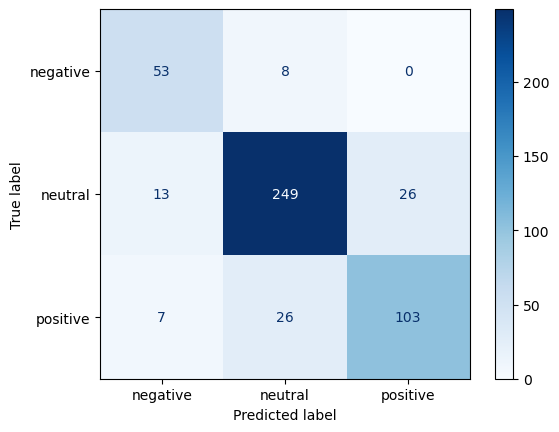

In [200]:
disp = ConfusionMatrixDisplay(confusion_matrix_result, display_labels=list(sentiment_map.keys()))
colormap = cm.Blues

disp.plot(cmap=colormap)
plt.show()


### use the fine-tuned model

In [195]:
def get_sentiment(sentence):
    encoded_inputs = tokenizer(sentence, truncation=True, padding='max_length' , max_length=128)
    input_ids = torch.tensor([encoded_inputs['input_ids']]).to(model.device)  # Convert to tensor and move to device (CPU or GPU)
    attention_mask = torch.tensor([encoded_inputs['attention_mask']]).to(model.device)
    token_type_ids = torch.tensor([encoded_inputs['token_type_ids']]).to(model.device)  # Include if your model uses them
    # Create a single-element batch
    batch = {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'token_type_ids': token_type_ids  # Include if applicable
    }
    with torch.no_grad():  # Disable gradient calculation for efficiency
      outputs = model(**batch)
      predictions = torch.argmax(outputs.logits, dim=-1)  # Get the predicted class index
    predicted_label = predictions.item()
    predicted_label = predictions.item()
    if predicted_label == 0:
      sentiment = "negative"  # Explicit handling for label 0
    elif predicted_label == 1:
        sentiment = "neutral"
    else:
        sentiment = "positive"
    return(f"Predicted sentiment for '{sentence}': {sentiment}")

In [202]:
# get_sentiment(filtered_df['sentence'].iloc[0])
sentence_1 = 'Pinterest Stock Has 30% Upside, According to 1 Wall Street Analyst' 
sentence_2 = 'Tiny Telehealth Stock Sinks 85% as Wild IPO Rally Collapses'
sentence_3 = 'Global stocks climb to record highs as investors cheer economic recovery '
sentence_4 = 'Chinese Cement Maker Halted After 99% Crash in 15 Minutes'
sentence_5 = 'Here’s the good news in a troubling inflation report'
sentence_6 = 'Tiny Telehealth Stock Sinks 85% as Wild IPO Rally Collapses'
sentence_7 = 'US Inflation Refuses to Bend, Fanning Fears It Will Stick'
sentence_8 = 'Apple Stock Has 33% Upside, According to 1 Wall Street Analyst'
sentence_9 = 'Forget FAANG and the "Magnificent Seven" -- These "AI Five" Stocks Are Screaming Buys Right Now'
sentence_10 = 'Unemployment Rate Falls to Lowest Level in Decades, Economic Optimism Rises'
sentence_11 = 'An unexpected airline has started bringing in serious profits'     #negative, but i think its positive
sentence_12 = 'Apple Cut at Least 600 Workers When Car, Screen Projects Stopped'
print(get_sentiment(sentence_1))
print(get_sentiment(sentence_2))
print(get_sentiment(sentence_3))
print(get_sentiment(sentence_4))
print(get_sentiment(sentence_5))
print(get_sentiment(sentence_6))
print(get_sentiment(sentence_7))
print(get_sentiment(sentence_8))
print(get_sentiment(sentence_9))
print(get_sentiment(sentence_10))
print(get_sentiment(sentence_11))
print(get_sentiment(sentence_12))

Predicted sentiment for 'Pinterest Stock Has 30% Upside, According to 1 Wall Street Analyst': positive
Predicted sentiment for 'Tiny Telehealth Stock Sinks 85% as Wild IPO Rally Collapses': negative
Predicted sentiment for 'Global stocks climb to record highs as investors cheer economic recovery ': positive
Predicted sentiment for 'Chinese Cement Maker Halted After 99% Crash in 15 Minutes': negative
Predicted sentiment for 'Here’s the good news in a troubling inflation report': neutral
Predicted sentiment for 'Tiny Telehealth Stock Sinks 85% as Wild IPO Rally Collapses': negative
Predicted sentiment for 'US Inflation Refuses to Bend, Fanning Fears It Will Stick': negative
Predicted sentiment for 'Apple Stock Has 33% Upside, According to 1 Wall Street Analyst': positive
Predicted sentiment for 'Forget FAANG and the "Magnificent Seven" -- These "AI Five" Stocks Are Screaming Buys Right Now': neutral
Predicted sentiment for 'Unemployment Rate Falls to Lowest Level in Decades, Economic Opt